<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep11-eda-modeling?scriptVersionId=123818840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Description](#4)

[5. Data Exploration](#5)

[6. Baseline Modeling 1.0](#6)

[7. Baseline Modeling 2.0](#7)

[8. How many features?](#8)

[9. Baseline Modeling 3.0](#9)

[10. Baseline Modeling 3.5](#10)

[11. Baseline Modeling 4.0](#11)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (03/20/2023)
    * EDA 
    * Baseline modeling 1.0    
    
2. Version 2 (03/20/2023)
    * Baseline modeling 1.0 updated

3. Version 3 (03/20/2023)
    * Fixing bug 

4. Version 4 (03/21/2023)
    * Baseline modeling 1.0 updated
    
5. Version 5 (03/22/2023)
    * Baseline modeling 2.0 added
    * How many features added

6. Version 6 (03/25/2023)
    * Baseline modeling 3.0 added
    
7. Version 7 (03/28/2023)
    * Baseline modeling 3.5 added
    
8. Version 8 (03/29/2023)
    * Baseline modeling 4.0 added
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1> 

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, mean_squared_log_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e11/train.csv')
test = pd.read_csv('../input/playground-series-s3e11/test.csv')
submission = pd.read_csv('../input/playground-series-s3e11/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (360336, 17)
The dimession of the test dataset is: (240224, 16)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [4]:
train.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [5]:
train.describe()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000
mean,180167.500000,6.337376,3.043881,2.456482,0.689390,2.203813,13.822071,0.568086,0.327797,18.972706,28180.333442,0.564839,0.277394,0.504807,0.504832,0.503191,99.614729
std,104020.187637,3.307980,0.784676,1.488992,1.214732,1.084293,4.614792,0.495343,0.469411,10.212912,5968.874074,0.495779,0.447713,0.499978,0.499977,0.499991,29.939435
min,0.000000,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,90083.750000,3.720000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.320000
50%,180167.500000,5.780000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.810000
75%,270251.250000,8.400000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,360335.000000,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


In [6]:
test.describe()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
count,240224.00000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000,240224.000000
mean,480447.50000,6.353813,3.043930,2.454039,0.685381,2.198173,13.828380,0.565747,0.326928,18.959933,28174.648840,0.564173,0.275647,0.504396,0.504429,0.501815
std,69346.83987,3.307402,0.782982,1.487416,1.211368,1.085129,4.623458,0.495660,0.469092,10.216219,5974.494735,0.495866,0.446841,0.499982,0.499981,0.499998
min,360336.00000,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,420391.75000,3.750000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,480447.50000,5.800000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,540503.25000,8.400000,4.000000,4.000000,1.000000,3.000000,17.800000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,600559.00000,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. 
</div>

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>

This is a synthetic dataset generated from the [Media Campaign Cost Prediction](https://www.kaggle.com/datasets/gauravduttakiit/media-campaign-cost-prediction) dataset. These are the descriptions of the variables in this dataset:

<ul>
    <li> store_sales(in millions): store_sales(in million dollars). </li>
    <li> unit_sales(in millions): unit_sales(in millions) in stores Quantity. </li>
    <li> Total_children: total children at home. </li>
    <li> avg_cars_at home(approx): average cars at home (approx). </li>
    <li> Num_children_at_home: number of children at home as per customers filled details. </li>
    <li> Gross_weight: gross weight of item. </li>
    <li> Recyclable_package: food item is recyble package. </li>
    <li> Low_fat: low fat food item is low fat. </li>
    <li> Units_per_case: units/case available in each store shelves. </li>
    <li> Store_sqft: store area available in square footage. </li>
    <li> Coffee_bar: coffee bar available in store. </li>
    <li> Video_store: video store/gaming store available. </li>
    <li> Salad_bar: salad bar available in store. </li>
    <li> Prepared_food: food prepared available in store. </li>
    <li> Florist: flower shelves available in store. </li>
    <li> Cost: cost on acquiring a customers in dollars. </li>
</ul>

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1> 

We first start by exploring the distribution of the `cost`.

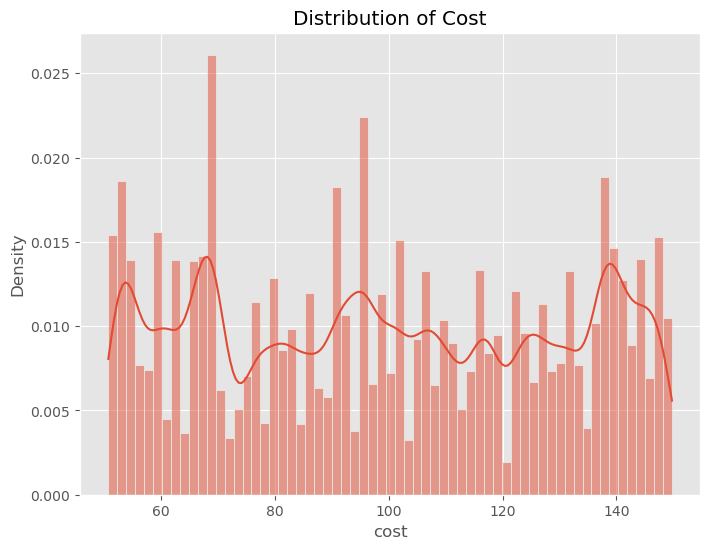

In [7]:
plt.figure(figsize = (8, 6))
sns.histplot(data = train['cost'], kde = True, stat = 'density', log_scale = False).set(title = 'Distribution of Cost');

> <div class="alert alert-block alert-info">
<b>💡</b> From the above histogram, we see the cost distribution is multi-modal. Beside the modes, the distribution looks a lite flat.</div>

Next, we proceed to visualize the correlations among the predictor variables and target variable in the train dataset, and the correlation among the predictor variables in the test dataset.

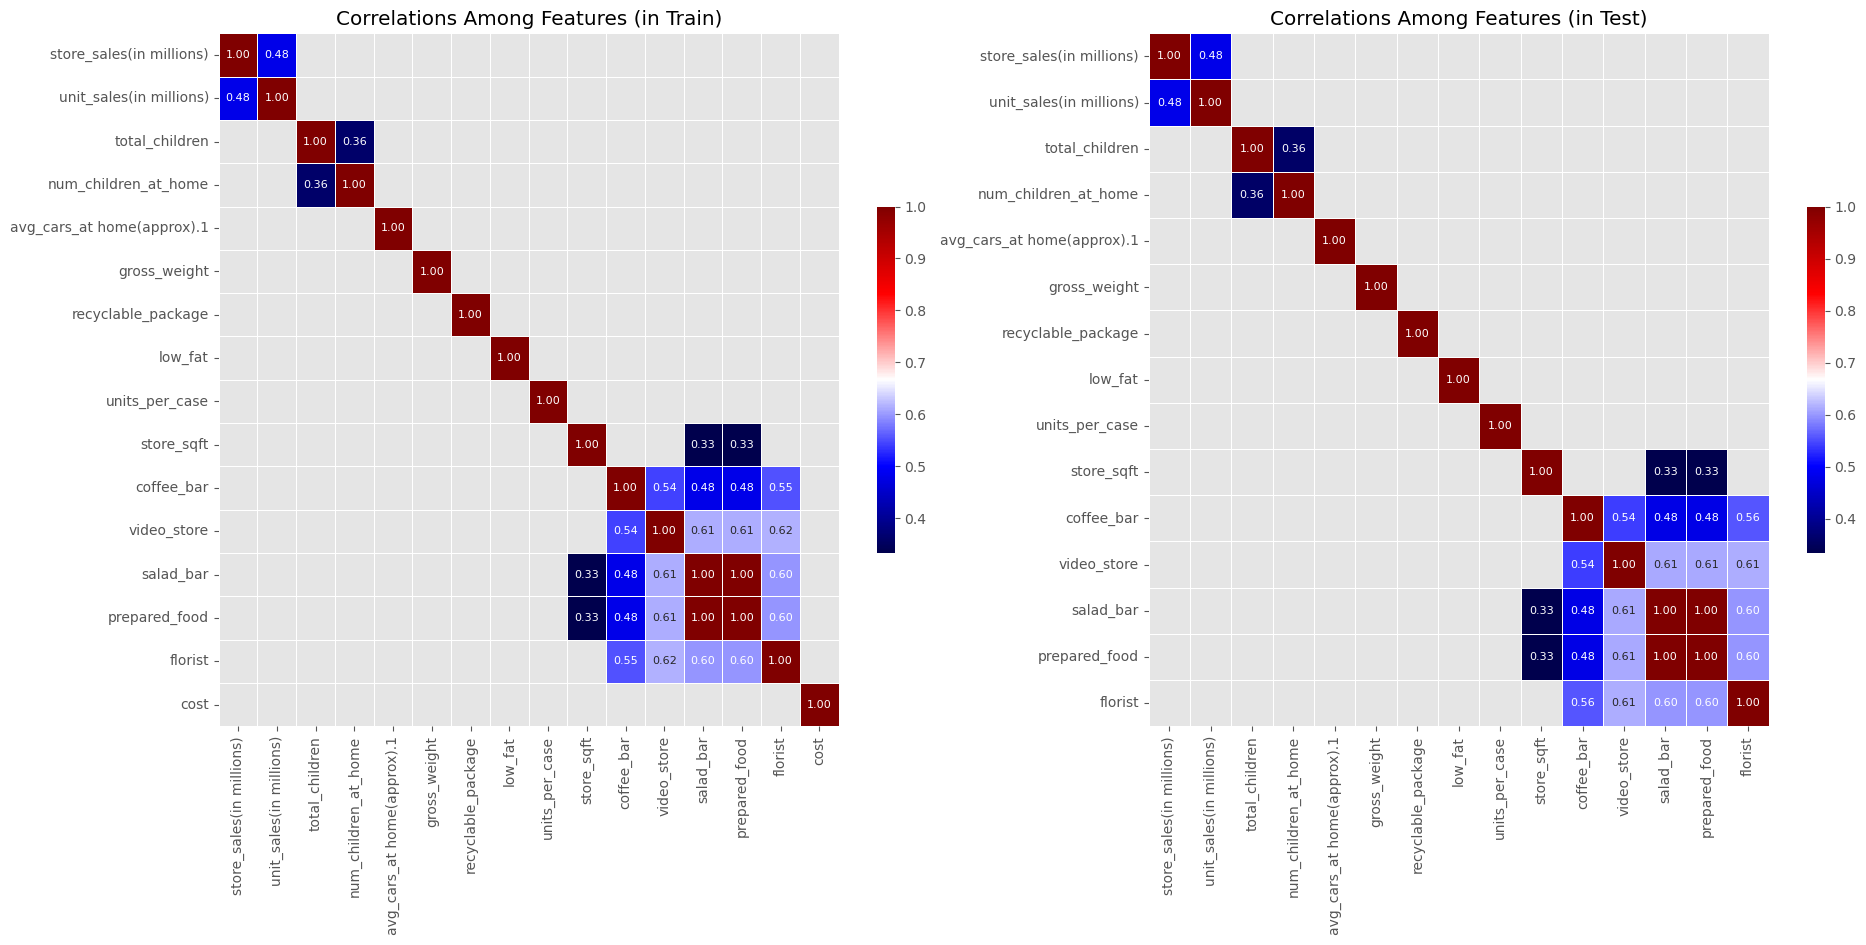

In [8]:
corr_mat_train = train.drop(columns = ['id'], axis = 1).corr()
corr_mat_test = test.drop(columns = ['id'], axis = 1).corr()

threshold = 0.2
corr_threshold_train = corr_mat_train[(corr_mat_train > threshold) | (corr_mat_train < -threshold)]
corr_threshold_test = corr_mat_test[(corr_mat_test > threshold) | (corr_mat_test < -threshold)]

fig, axes = plt.subplots(1, 2, figsize = (22, 9))
sns.heatmap(corr_threshold_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_threshold_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

> <div class="alert alert-block alert-info">
<b>💡</b> From the above heatmap, there is a modereate positive correlation among store amenities features such as coffe_bar, video_store, salad_bar and prepared_food. Also note that salad_bar and prepared_food have a very high correlation.</div>

In [9]:
print('In the train dataset, there are ', sum(train['salad_bar'] == train['prepared_food']), ' instances in which salad_bar is equal to prepared_food out of ', train.shape[0], ' instances') 
print('In the train dataset, there are ', sum(test['salad_bar'] == test['prepared_food']), ' instances in which salad_bar is equal to prepared_food out of ', test.shape[0], ' instances') 

In the train dataset, there are  360307  instances in which salad_bar is equal to prepared_food out of  360336  instances
In the train dataset, there are  240208  instances in which salad_bar is equal to prepared_food out of  240224  instances


We next proceed to compare the distributions of the features in the train and test datasets.

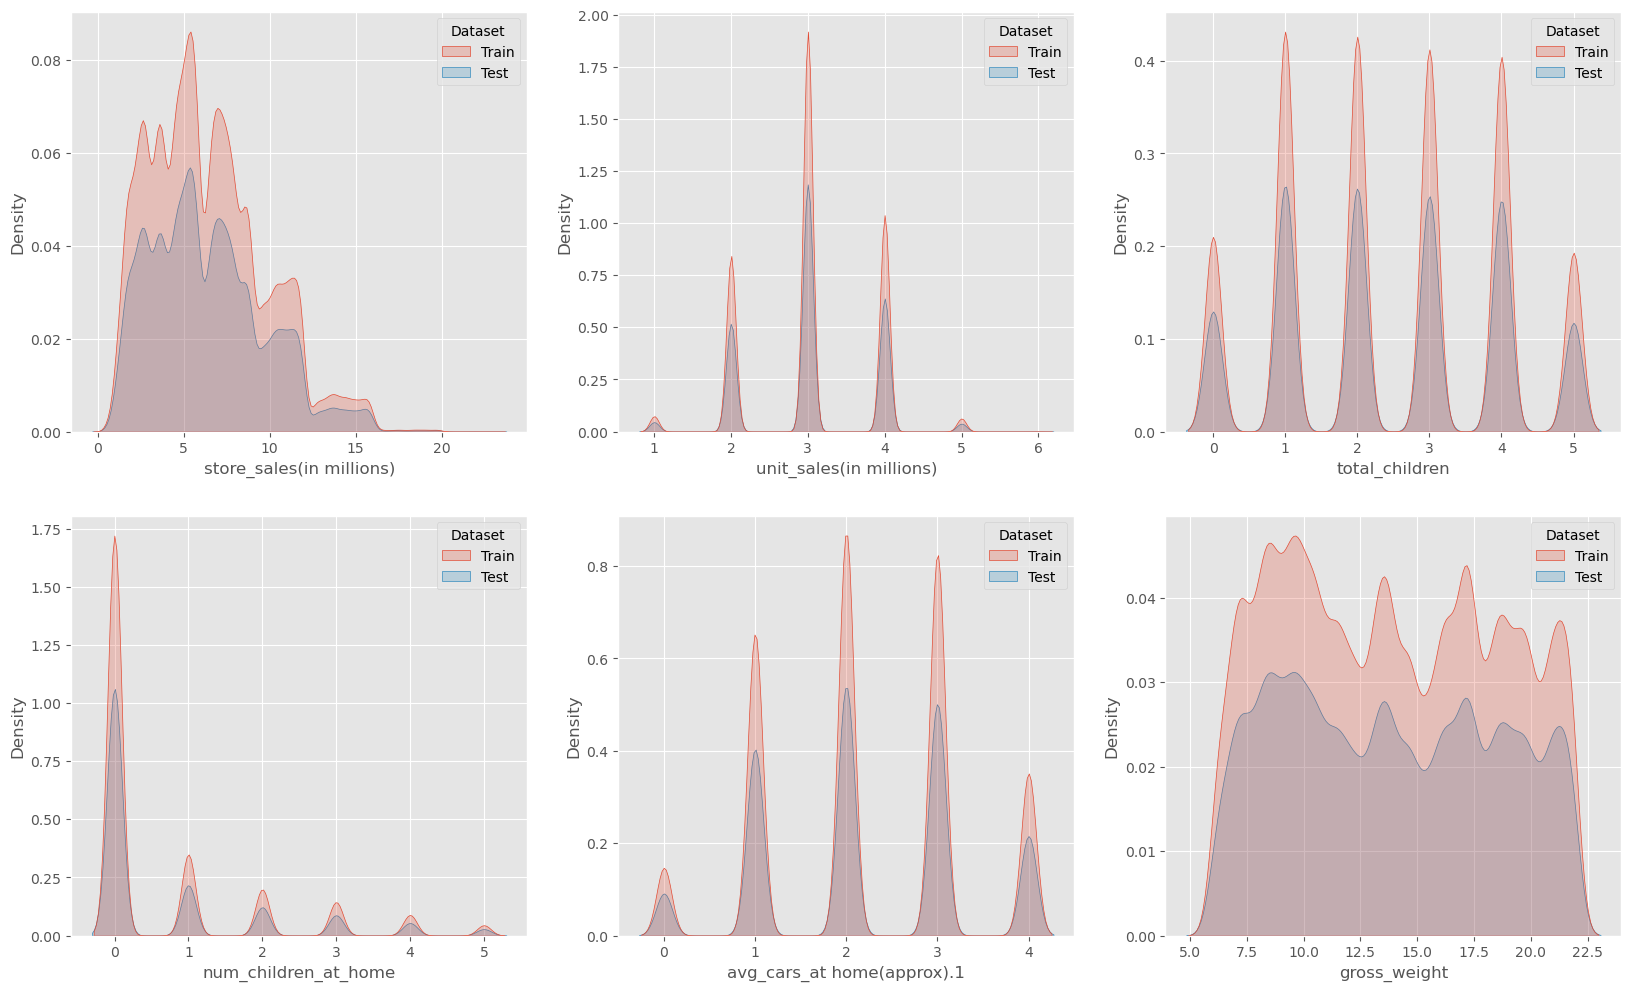

In [10]:
train_vis = train.drop(columns = 'cost', axis = 1).reset_index(drop = True).copy()
test_vis = test.copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0, 0], x = 'store_sales(in millions)', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'unit_sales(in millions)', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'total_children', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'num_children_at_home', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'avg_cars_at home(approx).1', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'gross_weight', hue = 'Dataset', data = data_tot, fill = True);

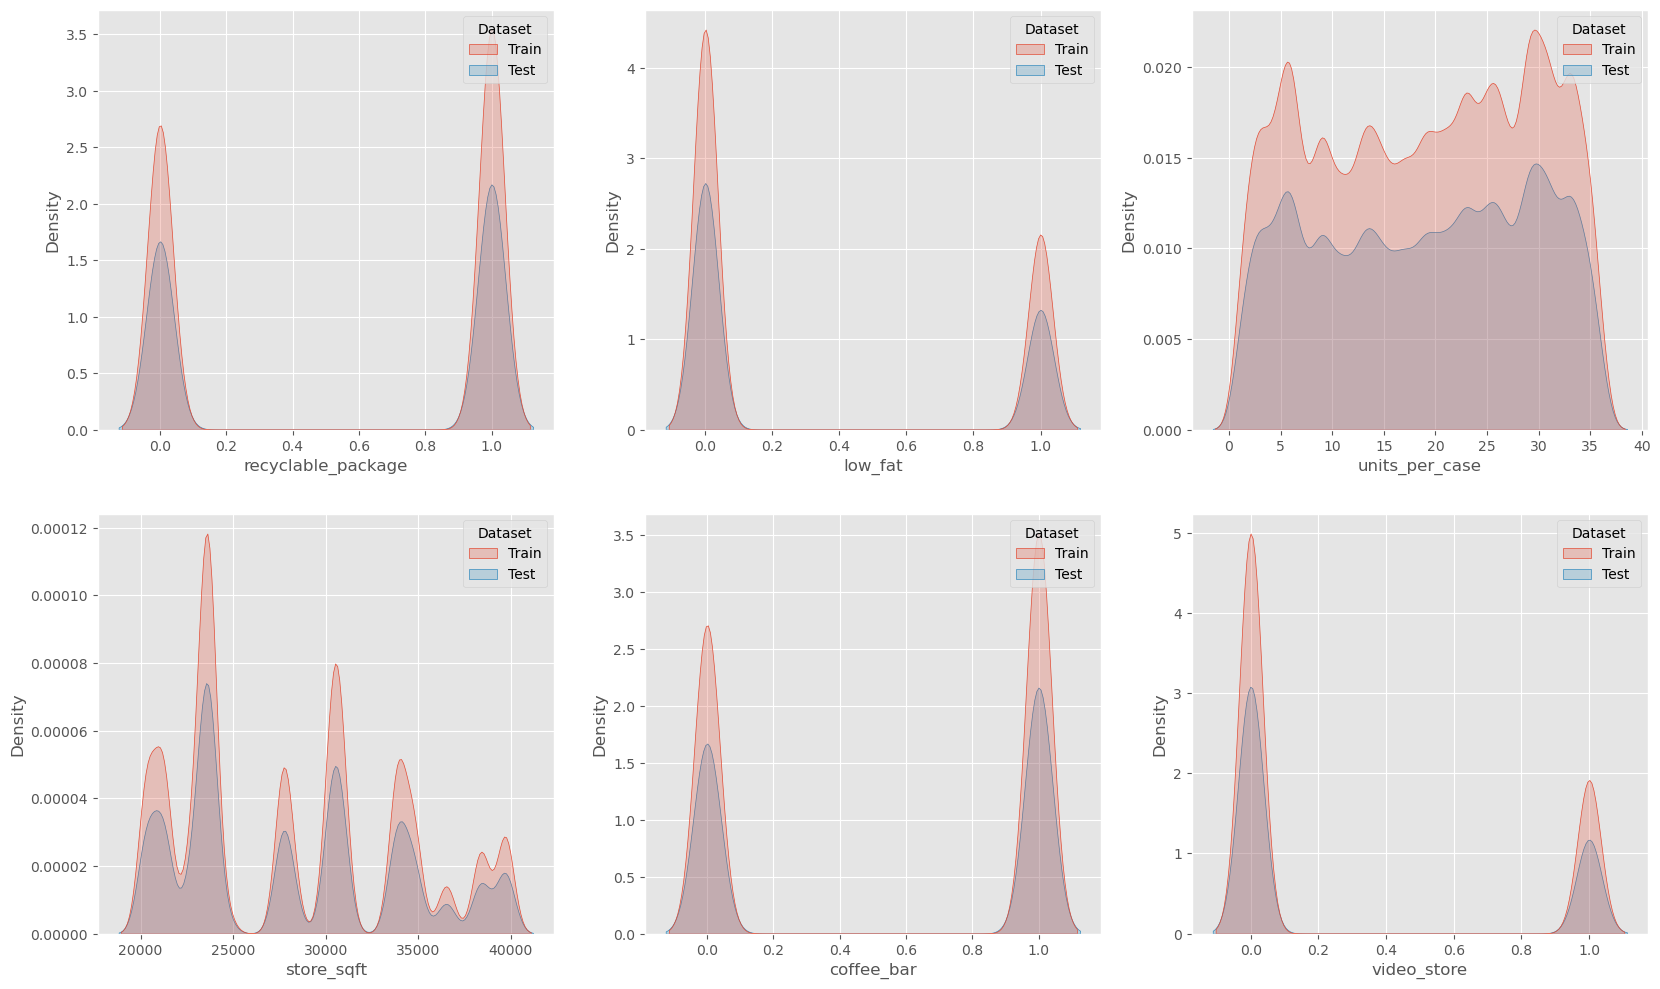

In [11]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0, 0], x = 'recyclable_package', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'low_fat', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'units_per_case', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'store_sqft', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'coffee_bar', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'video_store', hue = 'Dataset', data = data_tot, fill = True);

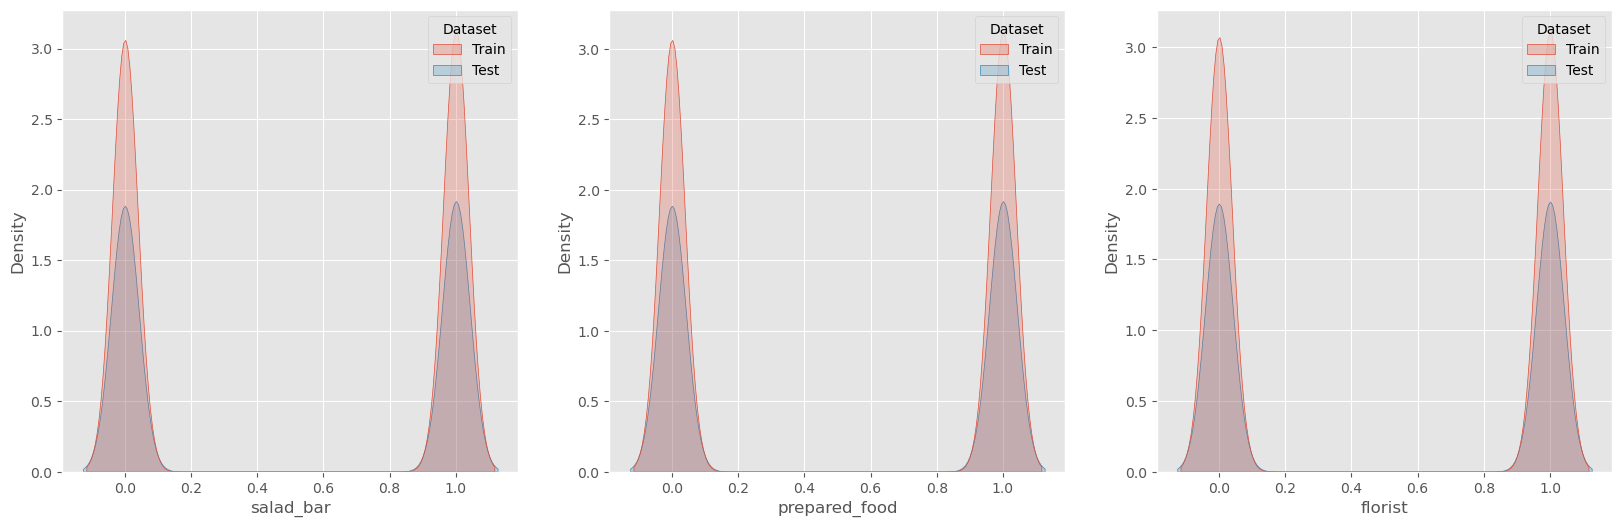

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6))

sns.kdeplot(ax = axes[0], x = 'salad_bar', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1], x = 'prepared_food', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2], x = 'florist', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above charts, the distributions of the features in train and test datasets look very similar.</div>

We next proceed check for duplicated obsevations.

In [13]:
print('There are ', train.shape[0], ' observations in the train datset')
print('There are ', train.drop(columns = ['id', 'cost'], axis = 1).drop_duplicates().shape[0], ' unique observations in the train datset')

print('There are ', test.shape[0], ' observations in the test datset')
print('There are ', test.drop(columns = ['id'], axis = 1).drop_duplicates().shape[0], ' unique observations in the test datset')

There are  360336  observations in the train datset
There are  360336  unique observations in the train datset
There are  240224  observations in the test datset
There are  240224  unique observations in the test datset


> <div class="alert alert-block alert-info">
<b>💡</b> From the above, we see there is not duplicated observations.</div>



In [14]:
to_consider = train.drop(columns = ['id', 'cost'], axis = 1).columns.tolist()
duplicates = pd.merge(train.drop(columns = ['id', 'cost'], axis = 1), test.drop(columns = ['id'], axis = 1), on = to_consider)

print('There are ', duplicates.shape[0], ' rows that appear in the train and test dataset.\n')

There are  0  rows that appear in the train and test dataset.



<a id="6"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

The first baseline modeling is based on three tree-based models. Notice that we are rounding the input variables (suggested in this [post](https://www.kaggle.com/competitions/playground-series-s3e11/discussion/396271)).

In [15]:
X = train.drop(columns = ['id', 'cost'], axis = 1)
X = X.round(0)

Y = train['cost']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline = test_baseline.round(0)

xgb_imp, lgb_imp = list(), list()
hist_cv_scores, lgb_cv_scores, xgb_cv_scores = list(), list(), list()
ens_cv_scores = list()
hist_preds, lgb_preds, xgb_preds, ens_preds = list(), list(), list(), list()

for i in tqdm(range(1)):

    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ##########################
        ## HistGradientBoosting ##
        ##########################
        
        hist_md = HistGradientBoostingRegressor(l2_regularization = 0.01,
                                                early_stopping = False,
                                                learning_rate = 0.01,
                                                max_iter = 1000,
                                                max_depth = 10,
                                                max_bins = 255,
                                                min_samples_leaf = 30,
                                                max_leaf_nodes = 30).fit(X_train, Y_train)
        
        ##############
        ## LightGBM ##
        ##############
        
        lgb_md = LGBMRegressor(n_estimators = 1000,
                               max_depth = 10,
                               learning_rate = 0.01,
                               num_leaves = 70,
                               lambda_l1 = 3,
                               lambda_l2 = 3,
                               bagging_fraction = 0.7,
                               feature_fraction = 0.7,
                               device = 'gpu').fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        #############
        ## XGBoost ##
        #############
        
        xgb_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.7, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 10, 
                              min_child_weight = 20, 
                              n_estimators = 1000, 
                              subsample = 0.7).fit(X_train, Y_train)
        xgb_imp.append(xgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        hist_pred_1 = hist_md.predict(X_test)
        hist_pred_2 = hist_md.predict(test_baseline)
        
        lgb_pred_1 = lgb_md.predict(X_test)
        lgb_pred_2 = lgb_md.predict(test_baseline)
        
        xgb_pred_1 = xgb_md.predict(X_test)
        xgb_pred_2 = xgb_md.predict(test_baseline)
        
        ## Ensemble 
        ens_pred = 0.1*hist_pred_1 + 0.4*lgb_pred_1 + 0.5*xgb_pred_1
        ens_pred_test = 0.1*hist_pred_2 + 0.4*lgb_pred_2 + 0.5*xgb_pred_2
        
        ## Computing rmse
        hist_cv_scores.append(mean_squared_log_error(Y_test, hist_pred_1, squared = False))
        lgb_cv_scores.append(mean_squared_log_error(Y_test, lgb_pred_1, squared = False))
        xgb_cv_scores.append(mean_squared_log_error(Y_test, xgb_pred_1, squared = False))
        ens_cv_scores.append(mean_squared_log_error(Y_test, ens_pred, squared = False))
        
        hist_preds.append(hist_pred_2)
        lgb_preds.append(lgb_pred_2)
        xgb_preds.append(xgb_pred_2)
        ens_preds.append(ens_pred_test)

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[Li

100%|██████████| 1/1 [09:36<00:00, 576.93s/it]


Next, we compare the performance of the models.

In [16]:
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
ens_cv_score = np.mean(ens_cv_scores)

md_perf = pd.DataFrame({'Model': ['HistGradient', 'LigthGBM', 'XGBoost', 'Ensemble'], 
                        'CV-Score': [hist_cv_score, lgb_cv_score, xgb_cv_score, ens_cv_score]})
md_perf.sort_values(by = 'CV-Score', ascending = False, inplace = True)
md_perf

,Model,CV-Score
0,HistGradient,0.303172
1,LigthGBM,0.302040
3,Ensemble,0.300927
2,XGBoost,0.300310


Next, we visualize model performances and correlations among the model predictions in the test dataset.

Text(0.5, 1.0, 'Correlations Among Model Predictions')

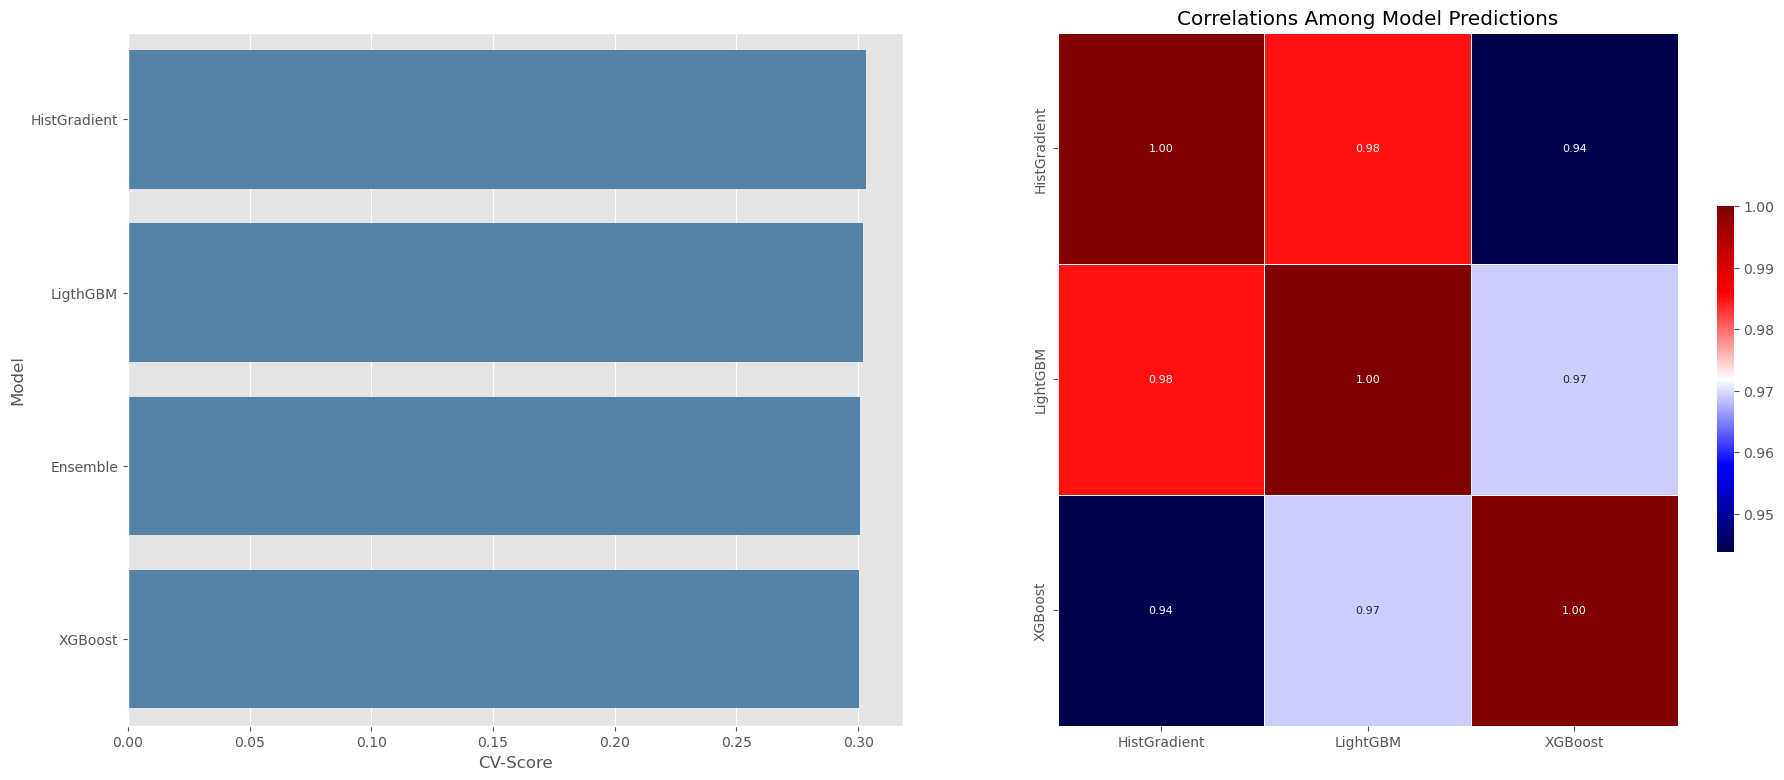

In [17]:
hist_preds_test = pd.DataFrame(hist_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

md_preds = pd.DataFrame({'HistGradient': hist_preds_test,
                         'LightGBM': lgb_preds_test, 
                         'XGBoost': xgb_preds_test})
corr_mat_pred = md_preds.corr()

fig, axes = plt.subplots(1, 2, figsize = (22, 9))

sns.barplot(ax = axes[0], data = md_perf, x = 'CV-Score', y = 'Model', color = 'steelblue')
sns.heatmap(corr_mat_pred, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Model Predictions')

Next, we visualize the importance of the features.

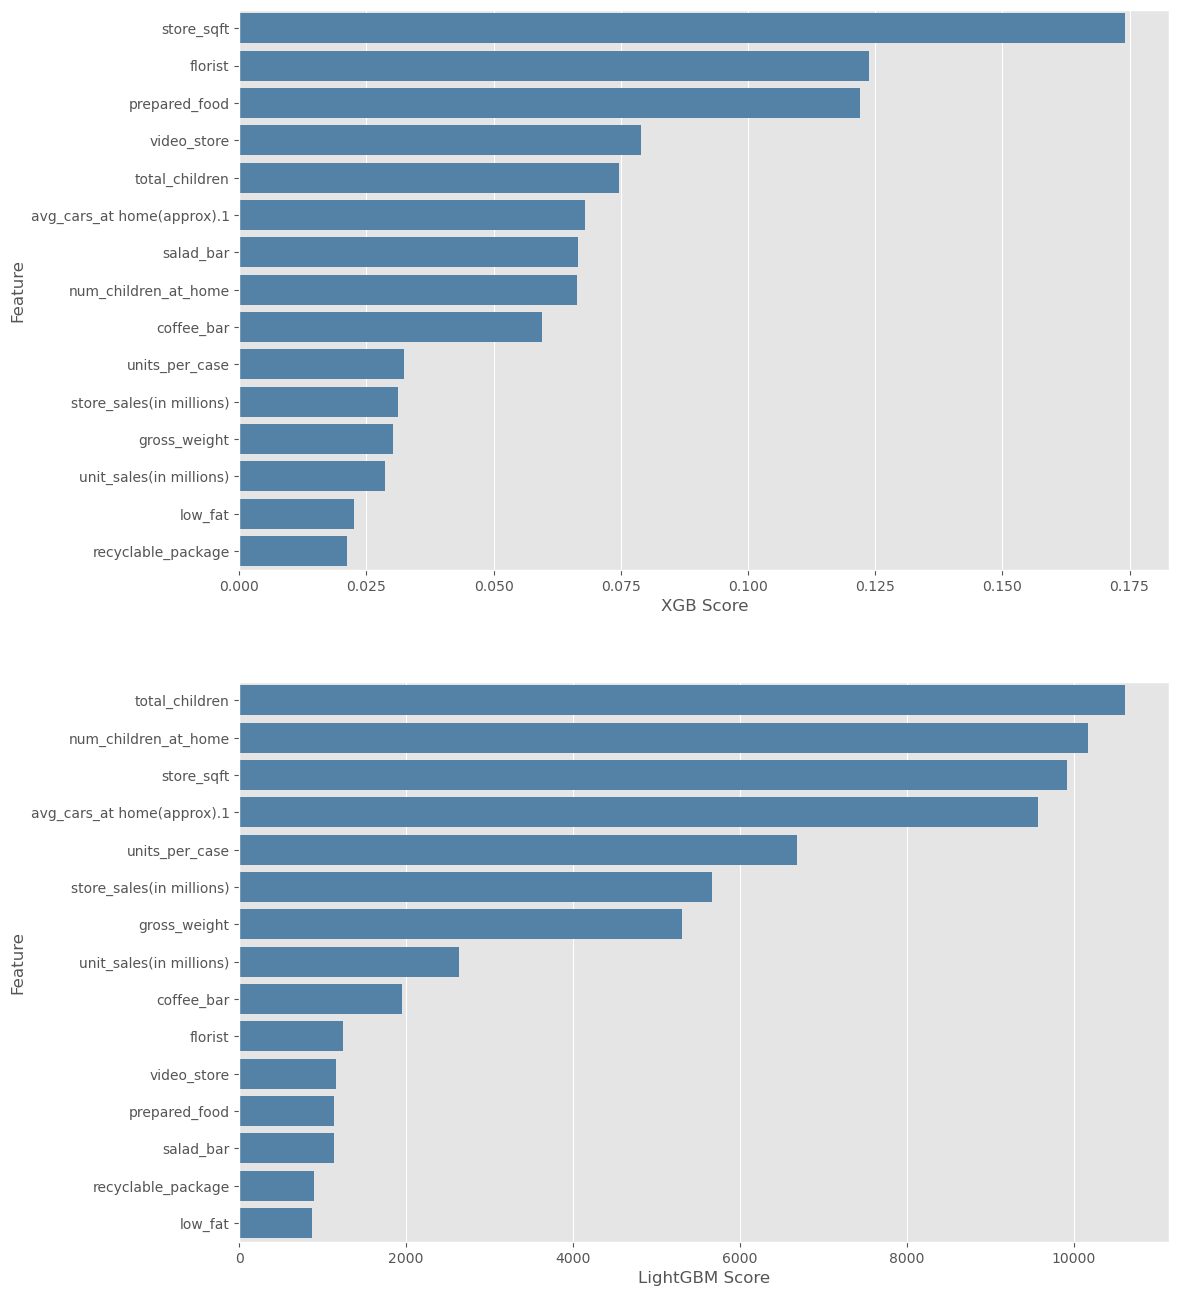

In [18]:
data1 = pd.DataFrame(pd.DataFrame(xgb_imp, columns = X.columns).apply(np.mean, axis = 0))
data1['Feature'] = data1.index
data1.columns = ['XGB Score', 'Feature']
data1.reset_index(drop = True, inplace = True)
data1.sort_values(by = 'XGB Score', ascending = False, inplace = True)

data2 = pd.DataFrame(pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0))
data2['Feature'] = data2.index
data2.columns = ['LightGBM Score', 'Feature']
data2.reset_index(drop = True, inplace = True)
data2.sort_values(by = 'LightGBM Score', ascending = False, inplace = True)

fig, axes = plt.subplots(2, 1, figsize = (12, 16))
sns.barplot(ax = axes[0], data = data1, x = 'XGB Score', y = 'Feature', color = 'steelblue')
sns.barplot(ax = axes[1], data = data2, x = 'LightGBM Score', y = 'Feature', color = 'steelblue');

In [19]:
submission['cost'] = hist_preds_test
submission.to_csv('Hist_Baseline_submission.csv', index = False)

submission['cost'] = lgb_preds_test
submission.to_csv('LightGBM_Baseline_submission.csv', index = False)

submission['cost'] = xgb_preds_test
submission.to_csv('XGBoost_Baseline_submission.csv', index = False)

submission['cost'] = ens_preds_test
submission.to_csv('Ensemble_Baseline_submission.csv', index = False)

<a id="7"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

There are a few dicussion posts that suggest that reducing the number of input features has a positive effect in the cv-score and LB. In this section, we re-train the XGBoost model (best model based on previous section results) only using the top 8 features based on XGBoost importance.

In [20]:
to_select = ['store_sqft',
             'florist',
             'prepared_food',
             'video_store',
             'total_children',
             'avg_cars_at home(approx).1',
             'num_children_at_home',
             'coffee_bar']

X = train.drop(columns = ['id', 'cost'], axis = 1)
X = X.round(0)
X = X[to_select]

Y = train['cost']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline = test_baseline.round(0)
test_baseline = test_baseline[to_select]

xgb_cv_scores, xgb_preds = list(), list()

for i in tqdm(range(1)):

    skf = KFold(n_splits = 10, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        #############
        ## XGBoost ##
        #############
        
        xgb_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.5757997153285994, 
                              gamma = 5.857273852352043, 
                              learning_rate = 0.01281984646506316, 
                              max_depth = 8, 
                              min_child_weight = 1, 
                              n_estimators = 4461, 
                              subsample = 0.725017851867728).fit(X_train, Y_train)
        
        ## Predicting on X_test and test        
        xgb_pred_1 = xgb_md.predict(X_test)
        xgb_pred_2 = xgb_md.predict(test_baseline)
                
        ## Computing rmse and storing test predictions
        xgb_cv_scores.append(mean_squared_log_error(Y_test, xgb_pred_1, squared = False))
        xgb_preds.append(xgb_pred_2)
        
xgb_cv_score = np.mean(xgb_cv_scores)
print('The oof mean-squared-log-error of the XGBoost model is ', xgb_cv_score)

100%|██████████| 1/1 [10:14<00:00, 614.32s/it]

The oof mean-squared-log-error of the XGBoost model is  0.2978016615272134


In [21]:
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
submission['cost'] = xgb_preds_test
submission.head()

,id,cost
0,360336,99.126999
1,360337,98.760498
2,360338,99.228943
3,360339,99.032310
4,360340,82.734489


In [22]:
submission.to_csv('xgb_submission_10_fold.csv', index = False)

<a id="8"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">How many features?</h1>

In the previous secction, we train the XGBoost model with 8 features. By now, we know that less input features have a positive impact in model performance. The natural question is: how many features do we need to consider? In this section, we train the XGBoost model with two features, three features, four features and so on with the goal of comparing model performance.

In [23]:
to_select = ['store_sqft',
             'florist',
             'prepared_food',
             'video_store',
             'total_children',
             'avg_cars_at home(approx).1',
             'num_children_at_home',
             'coffee_bar',
             'units_per_case',
             'store_sales(in millions)']

X = train.drop(columns = ['id', 'cost'], axis = 1)
X = X.round(0)
X = X[to_select]

Y = train['cost']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline = test_baseline.round(0)
test_baseline = test_baseline[to_select]

xgb_2_cv_scores, xgb_3_cv_scores, xgb_4_cv_scores = list(), list(), list()
xgb_5_cv_scores, xgb_6_cv_scores, xgb_7_cv_scores = list(), list(), list()
xgb_8_cv_scores, xgb_9_cv_scores, xgb_10_cv_scores = list(), list(), list()


for i in tqdm(range(1)):

    skf = KFold(n_splits = 10, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        #############
        ## XGBoost ##
        #############
        
        xgb_md_2 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:2]], Y_train)
        
        xgb_md_3 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:3]], Y_train)
        
        xgb_md_4 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:4]], Y_train)
        
        xgb_md_5 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:5]], Y_train)
        
        xgb_md_6 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:6]], Y_train)
        
        xgb_md_7 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:7]], Y_train)
        
        xgb_md_8 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:8]], Y_train)
        
        xgb_md_9 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:9]], Y_train)
        
        xgb_md_10 = XGBRegressor(tree_method = 'gpu_hist',
                                colsample_bytree = 0.7, 
                                gamma = 0.8, 
                                learning_rate = 0.01, 
                                max_depth = 10, 
                                min_child_weight = 20, 
                                n_estimators = 1000, 
                                subsample = 0.7).fit(X_train[to_select[0:10]], Y_train)
        
        xgb_md_2_pred = xgb_md_2.predict(X_test[to_select[0:2]])
        xgb_md_3_pred = xgb_md_3.predict(X_test[to_select[0:3]])
        xgb_md_4_pred = xgb_md_4.predict(X_test[to_select[0:4]])
        xgb_md_5_pred = xgb_md_5.predict(X_test[to_select[0:5]])
        xgb_md_6_pred = xgb_md_6.predict(X_test[to_select[0:6]])
        xgb_md_7_pred = xgb_md_7.predict(X_test[to_select[0:7]])
        xgb_md_8_pred = xgb_md_8.predict(X_test[to_select[0:8]])
        xgb_md_9_pred = xgb_md_9.predict(X_test[to_select[0:9]])
        xgb_md_10_pred = xgb_md_10.predict(X_test[to_select[0:10]])
                
        ## Computing mean squared log error
        xgb_2_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_2_pred, squared = False))
        xgb_3_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_3_pred, squared = False))
        xgb_4_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_4_pred, squared = False))
        xgb_5_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_5_pred, squared = False))
        xgb_6_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_6_pred, squared = False))
        xgb_7_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_7_pred, squared = False))
        xgb_8_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_8_pred, squared = False))
        xgb_9_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_9_pred, squared = False))
        xgb_10_cv_scores.append(mean_squared_log_error(Y_test, xgb_md_10_pred, squared = False))

100%|██████████| 1/1 [16:46<00:00, 1006.30s/it]


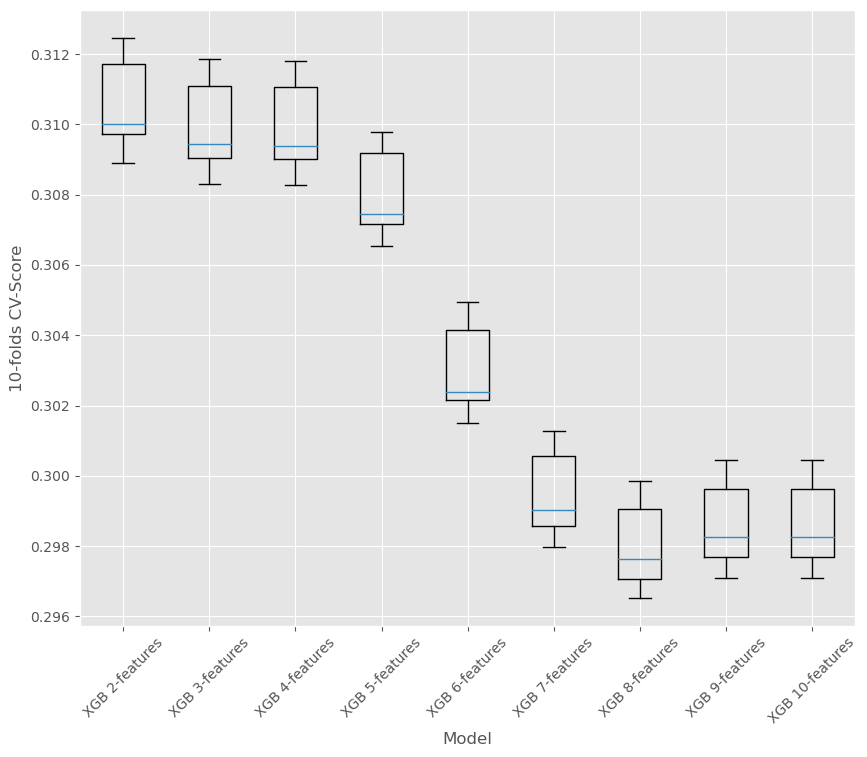

In [24]:
md_scores = pd.DataFrame({'XGB 2-features': xgb_2_cv_scores,
                          'XGB 3-features': xgb_3_cv_scores,
                          'XGB 4-features': xgb_4_cv_scores,
                          'XGB 5-features': xgb_5_cv_scores,
                          'XGB 6-features': xgb_6_cv_scores,
                          'XGB 7-features': xgb_7_cv_scores,
                          'XGB 8-features': xgb_8_cv_scores,
                          'XGB 9-features': xgb_9_cv_scores, 
                          'XGB 10-features': xgb_9_cv_scores})

plt.figure(figsize = (10, 8))

labels = ['XGB 2-features',
          'XGB 3-features',
          'XGB 4-features',
          'XGB 5-features',
          'XGB 6-features',
          'XGB 7-features',
          'XGB 8-features',
          'XGB 9-features',
          'XGB 10-features']

plt.boxplot(md_scores, labels = labels)
plt.xlabel('Model')
plt.ylabel('10-folds CV-Score')
plt.xticks(rotation = 45);

From the above chart, we see that the XGBoost model with top 8 featues is the one that has the best performance.

<a id="9"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 3.0</h1>

After running several experiments, I was able to come up with a great baseline model. In this case, I'm using LightGBM because it the one the run the fastest out of the models that I considered. Notice that I'm using a couple of ideas, which were shared in the discussion post (see this [post](https://www.kaggle.com/competitions/playground-series-s3e11/discussion/396291) or this [post](https://www.kaggle.com/competitions/playground-series-s3e11/discussion/396271)). We start by running 50 times a LightGBM tuned model with different seeds.

In [25]:
to_select = ['store_sqft',
             'florist',
             'prepared_food',
             'video_store',
             'total_children',
             'avg_cars_at home(approx).1',
             'num_children_at_home',
             'coffee_bar']

X = train.drop(columns = ['id', 'cost'], axis = 1)
X = X.round(0)
X = X[to_select].apply(lambda x: x.astype(int))
X['children_ratio'] = X['total_children'] / X['num_children_at_home']
X['children_ratio'].replace([np.inf, -np.inf], 10, inplace = True)
X['units_per_sq'] = train['unit_sales(in millions)'] / X['store_sqft']
X['florist'] = X['florist'].astype('category')
X['prepared_food'] = X['prepared_food'].astype('category')
X['video_store'] = X['video_store'].astype('category')
X['coffee_bar'] = X['coffee_bar'].astype('category')

Y = np.log(train['cost'])

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline = test_baseline.round(0)
test_baseline = test_baseline[to_select].apply(lambda x: x.astype(int))
test_baseline['children_ratio'] = test_baseline['total_children'] / test_baseline['num_children_at_home']
test_baseline['children_ratio'].replace([np.inf, -np.inf], 10, inplace = True)
test_baseline['units_per_sq'] = test['unit_sales(in millions)'] / test_baseline['store_sqft']
test_baseline['florist'] = test_baseline['florist'].astype('category')
test_baseline['prepared_food'] = test_baseline['prepared_food'].astype('category')
test_baseline['video_store'] = test_baseline['video_store'].astype('category')
test_baseline['coffee_bar'] = test_baseline['coffee_bar'].astype('category')

lgb_preds, loss = list(), list()
lgb_preds_train, lgb_preds_test = list(), list()

for i in tqdm(range(50)):
   
    ###########################
    ## LightGBM (best model) ##
    ###########################
        
    lgb_md = LGBMRegressor(n_estimators = 311,
                           max_depth = 10,
                           learning_rate = 0.08,
                           num_leaves = 75,
                           lambda_l1 = 0.1653,
                           lambda_l2 = 0.2615,
                           bagging_fraction = 0.8670,
                           feature_fraction = 0.8986,
                           random_state = i).fit(X, Y)
    
    lgb_preds_train.append(np.exp(lgb_md.predict(X)))
    lgb_preds_test.append(np.exp(lgb_md.predict(test_baseline)))

  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


  2%|▏         | 1/50 [00:16<13:22, 16.37s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


  4%|▍         | 2/50 [00:32<13:00, 16.26s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


  6%|▌         | 3/50 [00:50<13:29, 17.22s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


  8%|▊         | 4/50 [01:07<13:06, 17.11s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 10%|█         | 5/50 [01:25<12:58, 17.31s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 12%|█▏        | 6/50 [01:42<12:33, 17.13s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 14%|█▍        | 7/50 [02:01<12:45, 17.80s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 16%|█▌        | 8/50 [02:19<12:24, 17.72s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 18%|█▊        | 9/50 [02:35<11:52, 17.39s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 20%|██        | 10/50 [02:51<11:18, 16.95s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 22%|██▏       | 11/50 [03:10<11:28, 17.66s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 24%|██▍       | 12/50 [03:27<11:04, 17.48s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 26%|██▌       | 13/50 [03:44<10:33, 17.12s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 28%|██▊       | 14/50 [04:03<10:37, 17.72s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 30%|███       | 15/50 [04:19<09:58, 17.11s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 32%|███▏      | 16/50 [04:36<09:45, 17.23s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 34%|███▍      | 17/50 [04:53<09:23, 17.08s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 36%|███▌      | 18/50 [05:10<09:11, 17.23s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 38%|███▊      | 19/50 [05:26<08:43, 16.89s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 40%|████      | 20/50 [05:44<08:34, 17.16s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 42%|████▏     | 21/50 [06:04<08:37, 17.84s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 44%|████▍     | 22/50 [06:20<08:02, 17.24s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 46%|████▌     | 23/50 [06:37<07:45, 17.23s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 48%|████▊     | 24/50 [06:54<07:27, 17.23s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 50%|█████     | 25/50 [07:12<07:17, 17.48s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 52%|█████▏    | 26/50 [07:28<06:51, 17.13s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 54%|█████▍    | 27/50 [07:47<06:47, 17.70s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 56%|█████▌    | 28/50 [08:05<06:26, 17.57s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 58%|█████▊    | 29/50 [08:22<06:07, 17.48s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 60%|██████    | 30/50 [08:38<05:42, 17.14s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 62%|██████▏   | 31/50 [08:56<05:29, 17.34s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 64%|██████▍   | 32/50 [09:14<05:15, 17.55s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 66%|██████▌   | 33/50 [09:32<04:59, 17.61s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 68%|██████▊   | 34/50 [09:49<04:38, 17.43s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 70%|███████   | 35/50 [10:06<04:20, 17.38s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 72%|███████▏  | 36/50 [10:23<04:00, 17.20s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 74%|███████▍  | 37/50 [10:40<03:43, 17.21s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 76%|███████▌  | 38/50 [10:58<03:29, 17.49s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 78%|███████▊  | 39/50 [11:16<03:14, 17.65s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 80%|████████  | 40/50 [11:34<02:57, 17.71s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 82%|████████▏ | 41/50 [11:53<02:43, 18.16s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 84%|████████▍ | 42/50 [12:11<02:23, 17.92s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 86%|████████▌ | 43/50 [12:28<02:04, 17.78s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 88%|████████▊ | 44/50 [12:46<01:45, 17.64s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 90%|█████████ | 45/50 [13:04<01:29, 17.84s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 92%|█████████▏| 46/50 [13:22<01:12, 18.06s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 94%|█████████▍| 47/50 [13:40<00:53, 17.98s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 96%|█████████▌| 48/50 [13:58<00:36, 18.05s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


 98%|█████████▊| 49/50 [14:15<00:17, 17.69s/it]

[LightGBM] [Warning] lambda_l2 is set=0.2615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2615
[LightGBM] [Warning] bagging_fraction is set=0.867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867
[LightGBM] [Warning] feature_fraction is set=0.8986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8986
[LightGBM] [Warning] lambda_l1 is set=0.1653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1653


100%|██████████| 50/50 [14:32<00:00, 17.46s/it]


We next train a simple LightGBM stacker using the 50 predictions as input variables.

In [26]:
train_pred = pd.DataFrame(lgb_preds_train).T
test_pred = pd.DataFrame(lgb_preds_test).T

X = train_pred
Y = train['cost']

preds_test, scores = list(), list()

skf = KFold(n_splits = 30, random_state = 42, shuffle = True)

for train_idx, valid_idx in skf.split(X, Y):

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    Y_train , Y_valid = Y.iloc[train_idx] , Y.iloc[valid_idx]
            
    Y_train = np.log(Y_train)
            
    model = LGBMRegressor(boosting_type = 'gbdt', 
                          n_estimators = 1590, 
                          learning_rate = 0.00577,
                          max_depth = 4,
                          lambda_l1 = 0.0513,
                          lambda_l2 = 1.7467,
                          num_leaves = 11,
                          bagging_fraction = 0.6917,
                          feature_fraction = 0.6267).fit(X_train, Y_train)
    
    preds_valid = model.predict(X_valid)
    preds_valid = np.exp(preds_valid)
            
    score = mean_squared_log_error(Y_valid, preds_valid, squared = False)
    scores.append(score)
        
    preds_test.append(np.exp(model.predict(test_pred)))

[LightGBM] [Warning] bagging_fraction is set=0.6917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6917
[LightGBM] [Warning] lambda_l1 is set=0.0513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0513
[LightGBM] [Warning] feature_fraction is set=0.6267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6267
[LightGBM] [Warning] lambda_l2 is set=1.7467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7467
[LightGBM] [Warning] bagging_fraction is set=0.6917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6917
[LightGBM] [Warning] lambda_l1 is set=0.0513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0513
[LightGBM] [Warning] feature_fraction is set=0.6267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6267
[LightGBM] [Warning] lambda_l2 is set=1.7467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7467
[LightGBM] [Warning] bagging_fraction is set=0.6917, sub

In [27]:
print('The average oof rmsle of the stacker is ', np.mean(scores))

The average oof rmsle of the stacker is  0.2919112457527485


In [28]:
lgb_stacker_pred = pd.DataFrame(preds_test).apply(np.mean, axis = 0)
submission['cost'] = lgb_stacker_pred
submission.head()

,id,cost
0,360336,88.311153
1,360337,91.443249
2,360338,92.323894
3,360339,96.025667
4,360340,78.019764


In [29]:
submission.to_csv('lgb_stacker_submission.csv', index = False)

<a id="9"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 3.5</h1>

In [30]:
to_select = ['store_sqft',
             'florist',
             'prepared_food',
             'video_store',
             'total_children',
             'avg_cars_at home(approx).1',
             'num_children_at_home',
             'coffee_bar', 
             'low_fat']

X = train.drop(columns = ['id', 'cost'], axis = 1)
X = X.round(0)
X = X[to_select].apply(lambda x: x.astype(int))
X['store_sqft'] = np.log(X['store_sqft'])
X['florist'] = X['florist'].astype('category')
X['prepared_food'] = X['prepared_food'].astype('category')
X['video_store'] = X['video_store'].astype('category')
X['coffee_bar'] = X['coffee_bar'].astype('category')
X['avg_cars_at home(approx).1'] = X['avg_cars_at home(approx).1'].astype('category') 
X['low_fat'] = X['low_fat'].astype('category') 

Y_group = pd.qcut(train['cost'], 5, labels = [1, 2, 3, 4, 5])
Y = train['cost']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline = test_baseline.round(0)
test_baseline = test_baseline[to_select].apply(lambda x: x.astype(int))
test_baseline['store_sqft'] = np.log(test_baseline['store_sqft'])
test_baseline['florist'] = test_baseline['florist'].astype('category')
test_baseline['prepared_food'] = test_baseline['prepared_food'].astype('category')
test_baseline['video_store'] = test_baseline['video_store'].astype('category')
test_baseline['coffee_bar'] = test_baseline['coffee_bar'].astype('category')
test_baseline['avg_cars_at home(approx).1'] = test_baseline['avg_cars_at home(approx).1'].astype('category')
test_baseline['low_fat'] = test_baseline['low_fat'].astype('category') 

extra_cv_scores, extra_preds = list(), list()

for i in tqdm(range(1)):

    skf = StratifiedKFold(n_splits = 30, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y_group):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ################
        ## ExtraTrees ##
        ################
        
        Y_train = np.log(Y_train)
        
        extra_md = ExtraTreesRegressor(n_estimators = 500,
                                       max_depth = 15,
                                       min_samples_split = 10, 
                                       min_samples_leaf = 20, 
                                       n_jobs = -1).fit(X_train, Y_train)
        
        extra_pred_1 = np.exp(extra_md.predict(X_test))
        extra_pred_2 = np.exp(extra_md.predict(test_baseline))
        
        extra_cv_scores.append(mean_squared_log_error(Y_test, extra_pred_1, squared = False))
        extra_preds.append(extra_pred_2)
        
extra_cv_score = np.mean(extra_cv_scores)
print('The average oof mean-squared-log-error score of the ExtraTree model over 5-folds (run 5 times) is:', extra_cv_score)

100%|██████████| 1/1 [49:54<00:00, 2994.15s/it]

The average oof mean-squared-log-error score of the ExtraTree model over 5-folds (run 5 times) is: 0.2935398070534397


In [31]:
extra_preds_test = pd.DataFrame(extra_preds).apply(np.mean, axis = 0)
submission['cost'] = extra_preds_test
submission.head()

,id,cost
0,360336,92.017234
1,360337,93.213726
2,360338,93.832458
3,360339,98.679064
4,360340,76.881695


In [32]:
submission.to_csv('extra_submission_30.csv', index = False)

<a id="9"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 4.0</h1>

In this section, we re-train the LightGBM model; however, this time we include target-encoding using `store_sqft` as grouping features as of the input features of the model.

In [33]:
to_select = ['store_sqft',
             'florist',
             'prepared_food',
             'video_store',
             'total_children',
             'avg_cars_at home(approx).1',
             'num_children_at_home',
             'coffee_bar', 
             'low_fat']

X = train.drop(columns = ['id', 'cost'], axis = 1)
X = X.round(0)
X = X[to_select].apply(lambda x: x.astype(int))
X['store_sqft'] = np.log(X['store_sqft'])
X['florist'] = X['florist'].astype('category')
X['prepared_food'] = X['prepared_food'].astype('category')
X['video_store'] = X['video_store'].astype('category')
X['coffee_bar'] = X['coffee_bar'].astype('category')
X['avg_cars_at home(approx).1'] = X['avg_cars_at home(approx).1'].astype('category') 
X['low_fat'] = X['low_fat'].astype('category') 

Y = train['cost']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline = test_baseline.round(0)
test_baseline = test_baseline[to_select].apply(lambda x: x.astype(int))
test_baseline['store_sqft'] = np.log(test_baseline['store_sqft'])
test_baseline['florist'] = test_baseline['florist'].astype('category')
test_baseline['prepared_food'] = test_baseline['prepared_food'].astype('category')
test_baseline['video_store'] = test_baseline['video_store'].astype('category')
test_baseline['coffee_bar'] = test_baseline['coffee_bar'].astype('category')
test_baseline['avg_cars_at home(approx).1'] = test_baseline['avg_cars_at home(approx).1'].astype('category')
test_baseline['low_fat'] = test_baseline['low_fat'].astype('category') 

lgb_cv_scores, lgb_preds = list(), list()

for i in tqdm(range(1)):

    skf = KFold(n_splits = 30, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ###################################
        ## LightGBM with target encoding ##
        ###################################
        
        Y_train = np.log(Y_train)
        
        temp_data = pd.DataFrame({'store_sqft': X_train['store_sqft'], 'encoded_target': Y_train})
        temp_data = temp_data.groupby('store_sqft')['encoded_target'].mean().reset_index()
        
        X_train = pd.merge(X_train, temp_data, on = 'store_sqft', how = 'left')
        X_train.drop(columns = ['store_sqft'], axis = 1, inplace = True)
        
        X_test = pd.merge(X_test, temp_data, on = 'store_sqft', how = 'left')
        X_test.drop(columns = ['store_sqft'], axis = 1, inplace = True)
        
        test_baseline_cv = test_baseline 
        test_baseline_cv = pd.merge(test_baseline_cv, temp_data, on = 'store_sqft', how = 'left')
        test_baseline_cv.drop(columns = ['store_sqft'], axis = 1, inplace = True)
        
        lgb_md = LGBMRegressor(n_estimators = 3053,
                               max_depth = 13,
                               learning_rate = 0.13588,
                               num_leaves = 100,
                               lambda_l1 = 0.7848,
                               lambda_l2 = 0.0715,
                               bagging_fraction = 0.4284,
                               feature_fraction = 0.7489,
                               verbosity = -1).fit(X_train, Y_train)
        
        lgb_pred_1 = np.exp(lgb_md.predict(X_test))
        lgb_pred_2 = np.exp(lgb_md.predict(test_baseline_cv))
        
        lgb_cv_scores.append(mean_squared_log_error(Y_test, lgb_pred_1, squared = False))
        lgb_preds.append(lgb_pred_2)

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.4284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4284
[LightGBM] [Warning] lambda_l1 is set=0.7848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7848
[LightGBM] [Warning] feature_fraction is set=0.7489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7489
[LightGBM] [Warning] lambda_l2 is set=0.0715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0715
[LightGBM] [Warning] bagging_fraction is set=0.4284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4284
[LightGBM] [Warning] lambda_l1 is set=0.7848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7848
[LightGBM] [Warning] feature_fraction is set=0.7489, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7489
[LightGBM] [Warning] lambda_l2 is set=0.0715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0715
[LightGBM] [Warning] bagging_fraction is set=0.4284, sub

100%|██████████| 1/1 [47:20<00:00, 2840.69s/it]


In [34]:
lgb_cv_score = np.mean(lgb_cv_scores)
print('The average oof mean-squared-log-error score of the LightGBM (with target encoding) model over 5-folds (run 5 times) is:', lgb_cv_score)

The average oof mean-squared-log-error score of the LightGBM (with target encoding) model over 5-folds (run 5 times) is: 0.29321533631423174


In [35]:
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
submission['cost'] = lgb_preds_test
submission.head()

,id,cost
0,360336,90.812034
1,360337,93.216582
2,360338,94.430554
3,360339,97.839774
4,360340,77.537630


In [36]:
submission.to_csv('lgb_submission_30_fold_target_encoding.csv', index = False)